# Lesson 2 - Feedforward models

This lesson will present the *dataflow* paradigm and its application to Artificial Neural Networks.
All the operations required to create an ANN will be implemented from scratch, and finally used to solve a regression task.

### Summary

* [Classical visualization of ANNs](#classicalANNs)
* [The *dataflow* paradigm](#dataflow)
* [Operations](#operations)
* [Running a *dataflow* program](#rundataflowprog)
* [Reinterpreting the *backpropagation* algorithm](#dataflowbackprop)
* [The *Boston housing prices* problem](#bostonhousing)


<a id=classicalANNs></a>
### Classical visualization of ANNs

Our way to think to problems is strongly influenced by the way we visualize them.
Artificial Neural Networks visualization has been strongly influenced by biological neural networks.
The fundamental processing units, the neurons, are usually depicted as small circles plus their connections.
In the picture below, we highlighted a neuron nucleus in gold, its synapsis (i.e. incoming signals channels) in green and its dendrites (i.e. outgoing signals channels) in turquoise.

<img src='figures/neuralnet_classic.png', width=360, height=360></img>

Although simple, this representation system is highly misleading from a mathematical modelling perspective.
In fact, it induces a graph representation in our mind, thinking to neurons' nucleuses as nodes and connections as directed edges.
It perfectly depicts the structure of the ensemble of fundamental units, but does not convey much of the **hierarchy of feature maps** that each layer of neurons applies to the preceding layers' features.

We can think to the ensemble of the states of the neurons in a particular layer as coordinates of points in a vector space (or its natural extension, a **tensor space**).

<img src='figures/neuralnet_classic_hierarchy.png', width=360, height=360></img>

First, the ANN *looks* at a point $x \in X$ using its input layer (the cyan one in figure); the connections between the input layer and the second (hidden) layer then transform this point into a point $\phi(x) \in \Phi$ in what is called a *latent representation* or **feature** (the green one in figure); finally, the connections from the hidden layer to the output layer trasform this feature into a point $y = f(\phi(x))$ (the magenta one in figure) in the desired output space $Y$.

The main change of paradigm in visualization of ANNs is passing from node=neuron/edge=connection graphs to **node=feature map/edge=tensor data structure** graphs.


<a id=dataflow></a>
### The *dataflow* paradigm

[Dataflow](https://en.wikipedia.org/wiki/Dataflow_programming) is a programming model that thinks to programs as computational graphs, graphs which **nodes are operations** and which **edges contain data that are consumed and produced by the operations** they connect.
We will call consumed data *operands* and produced data *results*.

Why is the *dataflow* paradigm so important for ANNs research?
The main reason is that graph representation of a program exposes important computational optimizations:
* **concurrency**, due to the explicit definition of dependencies (edges);
* **distributed computing**, thanks to the operations placement which is possible due to the operations modeling (nodes).

The degree of concurrency enabled by parallel architectures and parallel programming models played a critical role in the Artificial Neural Networks boom of the last ten years.

<img src='figures/google_dl.png', width=480, height=480></img>

Mastering the **dataflow programming model** requires to approach the programming problem in four stages.
The first three stages compose a **building phase** during which the graph is assembled.
The last stage represents the **execution phase**, when the graph is *brought to life* flowing data through it.

The four stages are:
* **design** an analytical model for you problem;
* **identify the transformations** required by the model;
* **assemble these tranformations consistently**, i.e. respecting their hierarchical dependencies;
* **flow data through the model**, feeding suitable input data to the first transformations and then executing other operations as soon as their required operands become available.

To get a grasp on these concepts, we will go step by step through an example.

During a data analysis, we **designed a statistical model**, parametric in $\theta=(b_1, w_1, w_2)$, expressed by the analytical function:

$$\begin{align} f(x, \theta=(b_1, w_1, w_2)) &= h(x, b_1, w_1)w_2 \\ &= \sigma(\nu(x)w_1 + b_1)w_2 \\ &= \sigma((x - \bar{x})w_1 + b_1)w_2 \end{align}$$

This decomposition highlights the dependencies of each stage of computation on preceeding elements.
Thus we can proceed to **identify the required elementary transformations** proceeding backward from the last (higher level) operation, iteratively asking **"Which operands are required to compute this feature?"**:
* the last operation is $f(x, \theta=(b_1, w_1, w_2)) = h(x, b_1, w_1)w_2$, that it is the product between a vector $h$ and a matrix $w_2$; these operands come from distinct operations;
* $w_2$ is a parameter of our model, so it is data that should just be emitted by some *emitting operation* which has no required dependencies; since parameters can be changed, this operation should somehow allow to emit different data depending on the moment it is executed;
* $h = h(x, b_1, w_1)$ is itself the otput of an operation $h(x, b_1, w_1) = \sigma(\nu(x)w_1 + b_1)$, which requires as operand the quantity $s_1 = \nu(x)w_1 + b_1$;
* $s_1$ is the sum of two operands, namely $\nu(x)w_1$ and $b_1$;
* we can apply to $b_1$ the same reasoning that we applied to $w_2$;
* $\nu(x)w_1$ is the vector-matrix product of the two  operands $\nu(x)$ and $w_1$;
* we can apply to $w_1$ the same reasoning that we applied to $w_2$ and $b_1$;
* $\nu(x) = x - \bar{x}$ is obtained as the difference betweend the independent operands $x$ and $\bar(x)$;
* $\bar{x}$ is not a parameter, but an external constant that should be always emitted equal to itself (where a parameter could change);
* finally, $x$ is the actual input to the statistical model, the observation of the reality: it should be emitted by an operation which is be fed by the real world.

This analysis corresponds to the computational graph depicted below.

<img src='figures/dataflow.png', width=480, height=480></img>

We see that we have **input nodes** that contain:
* data that can be fed in by the real world: **placeholder** operation;
* constant information: **constant** operation;
* parametric information, that can be changed as required: **variable** operations.

Then, we have *real* operations in the form of **internal nodes**:
* **sum** node;
* **vector-matrix multiplication** nodes;
* **sigmoid activation** node.

We said before that the intermediate feature spaces represented by ANNs layers actually are vector or tensor spaces.
Due to the inherent structure of vector and tensor spaces, points in these spaces are naturally encoded by multidimensional arrays data structures.
Thus, **operations** (the circles representing the graph nodes) eventually consume and produce data in the form of **tensors** (the squares on the edges).
Usually, the output tensor of the last feature map is not considered as an edge, since it is not consumed by any operation.

To simplify the program management, operation placement and data transfer, operations and their output tensor are usually merged into a single implemented object called `Node`.

<img src='figures/dataflow_implementation.png', width=480, height=480></img>

Such an object should store basically three attributes:
* `inbound_nodes`, a list of the **nodes whose output is required by the current node**, i.e. the nodes that provide operands to it;
* `outbound_nodes`, a list of **nodes that will use the current node's output**, i.e. the nodes to which it provides operands;
* `state`, an array to store **the result of the operation**; the output tensor itself!

The node should also have a method:
* `forward`, an algorithm to consume the inputs (operands) and produce its output (result).

When a `Node` object is created, it should be linked to the `Node`s that contain its required operand.
Thus, the `__init__` method of such a class should update the information about the graph's connectivity, taking a `list` of inbound `Node`s and communicating to them that the currently created `Node` requires their state (i.e. updating their `outbound_nodes` attribute).
Notice that the connectivity information added by the constructor method of a `Node` is local, since it regards only the edged which have the current `Node` as an extremum.

To visualize this, the next figure highlights a subgraph realizing the feature map $s_1 = l_1(x) = \nu(x)w_1 + b_1$; this subgraph is composed by:
* an arbitrary node as the current node (magenta);
* its `inbound_nodes` (orange), containing the operands $\nu(x)$, $w_1$ and $b_1$;
* its `outbound_nodes` (sea green), where the output tensor $s_1$ is directed.

<img src='figures/dataflow_implementation_Node.png', width=480, height=480></img>


In [1]:
import numpy as np


class Node():
    def __init__(self, inbound_nodes=list()):
        self.inbound_nodes = inbound_nodes
        for node in self.inbound_nodes:
            node.outbound_nodes.append(self)
        self.outbound_nodes = list()
        self.state = None
    
    def forward(self):
        raise NotImplementedError
    

<a id=operations></a>
### Operations

#### Input operations
The basic operations of a *dataflow* graph are input operations.
These operations provide *raw data* to the program, data that is not preprocessed or transformed before being fed to the graph.

This information comes in three form:
* `Constant`, an operation which emits an operand always equal to itself; the value of the operand should be communicated to the operation at its creation;
* `Placeholder`, an operation which emits an operand that has been read from the external environment; its `forward` method should thus use a parameter `value` which reads the current observation from the environment;
* `Variable`, an operation which emits an operand that must be initialized by the operation's constructor method; this value is stored as the operation's state; the difference from `Constant` operations is that `Variable`s state could change during the model's life.


In [2]:
class Constant(Node):
    def __init__(self, value):
        Node.__init__(self)
        self.state = value
        
    def forward(self):
        pass

    
class Placeholder(Node):
    def __init__(self):
        Node.__init__(self)
        
    def forward(self, value=None):
        if value is not None:
            self.state = value
            
            
class Variable(Node):
    def __init__(self, initial_value):
        Node.__init__(self)
        self.state = initial_value
        
    def forward(self):
        pass
    

#### Linear maps and affine transformations

**Linear maps** are the most important transformations that can be applied to vector and tensor spaces.
Let $X$ and $S$ be two vector spaces, that we will call the *input space* and the *score space* respectively.
When both these spaces are finite-dimensional, with dimensions $n$ and $m$ respectively, a linear map

$$l: X \to S$$

can be algebraically described by a **vector-matrix multiplication**

$$\begin{gather} xW = \begin{pmatrix} x_1 & x_2 & \dots & x_n \end{pmatrix}
                      \begin{pmatrix} w_{11} & w_{12} & \dots & w_{1m} \\
                                      w_{21} & w_{22} & \dots & w_{2m} \\
                                      \vdots & \vdots & \ddots & \vdots \\
                                      w_{n1} & w_{n2} & \dots & w_{nm} \end{pmatrix}
\end{gather}$$

The result of this operation is a vector $s \in S$ which components are called *scores*

$$s_k = \sum_{i=1}^{n}x_i w_{ik}, k = 1, \dots m$$

The geometric meaning of this transformation is clear: the $k$-th component of $s$ is the result of a projection operation of $x$ onto the one-dimensional subspace of $X$ idetified by the $k$-th column of $W$:

$$s_k = \langle x, W^{(k)} \rangle, k = 1, \dots m$$

If we identify $X = \mathbb{R}^n$ and $S = \mathbb{R}^m$, linear algebra interprets the columns of $W$ as $m$ vectors *sprayed* in $\mathbb{R}^n$; we could imagine to give each of these vectors a physical interpretation like *cold*, *hot*, *blue* or *red*.
A point $x \in \mathbb{R}^n$ quantifies an observed objects in terms of numerical coordinates in $\mathbb{R}^n$; then the dot product $s_k = \langle x, W^{(k)} \rangle$ answers to the question *"how much is this object $x$ cold/hot/blue/red?"*.
The score space $\mathbb{R}^m$ will thus collect a higher level interpretation of the object point, namely $s = xW$.
These kind of abstractions are called **representations**.

Linear maps are constrained to represent rotations and homothecies around the origin, as shown by the [polar decomposition](https://en.wikipedia.org/wiki/Polar_decomposition), and consequently cannot account for translations.
To model such dependencies, a translation is usually added under the form of a **bias vector** $b \in S$:

$$\begin{align} l: \, &X \to S \\ &x \mapsto xW + b \end{align}$$


In [3]:
class Linear(Node):
    def __init__(self, x, w):
        Node.__init__(self, inbound_nodes=[x, w])
        
    def forward(self):
        x = self.inbound_nodes[0].state
        w = self.inbound_nodes[1].state
        self.state = np.dot(x, w)
        
        
class Add(Node):
    def __init__(self, s, b):
        Node.__init__(self, inbound_nodes=[s, b])
        
    def forward(self):
        s = self.inbound_nodes[0].state
        b = self.inbound_nodes[1].state
        self.state = s + b
        

#### Non-linear activations

As stated by the Universal Approximation Theorem, the power of ANNs emerges when they are able to **distort space to extract non-linear features**.

In order to achieve this, the output scores of linear transformations $s_k, k=1, \dots m$ should be filtered by **sigmoid** activations

$$\begin{align} y_k &= \sigma(s_k) \\ &= \frac{e^{s_k}}{e^{s_k} + 1}\end{align}$$

In practice, many non-linear functions can play the same role.
For example, the **hyperbolic tangent**

$$\begin{align} y_k &= \tanh(s_k) \\ &= 2\sigma(s_k) - 1 \end{align}$$

or the Leaky Rectified Linear Unit (**LeakyReLU**)

$$LeakyReLU_{q}(s_k) = \begin{cases} qs_k, & \mbox{if } s_k \leq 0 \\ s_k, & \mbox{if } s_k > 0 \end{cases}$$

where $q \geq 0$ is a design constant (the case $q = 0$ yields the widespreadly used **ReLU** function).

Why do they exist so many activation functions?
Should not sigmoid suffice due to the UAT?
Although in theory the LeakyReLU and the ReLU functions do not satisfy the hypothesis of the UAT, in real instances they do, and due to their minimal computational complexity with regard to sigmoids and hyperbolic tangents are thus largely used in real models.
Nevertheless, sigmoid and hyperbolic tangents are used since they allow more straightforward statistical interpretations:
* since $\sigma(s_k) \in (0, 1)$, sigmoid units can smoothly approximate boolean behaviour (e.g. the probability that a certain feature has been detected or not);
* since $\tanh(s_k) \in (-1, 1)$ carries sign information, hyperbolic tangent units can test wether a certain feature is inhibitory or excitatory.


In [4]:
class Sigmoid(Node):
    def __init__(self, x):
        Node.__init__(self, inbound_nodes=[x])
        
    def forward(self):
        x = self.inbound_nodes[0].state
        e_x = np.exp(x)
        self.state = e_x / (1+e_x)
        

class Tanh(Node):
    def __init__(self, x):
        Node.__init__(self, inbound_nodes=[x])
        
    def forward(self):
        x = self.inbound_nodes[0].state
        e_2x = np.exp(2*x)
        self.state = (e_2x - 1.0) / (e_2x + 1.0)
        
        
class LeakyReLU(Node):
    def __init__(self, q, x):
        Node.__init__(self, inbound_nodes=[x])
        self.q = q
        
    def forward(self):
        x = self.inbound_nodes[0].state
        mask = x > 0
        mask = mask + q * (1-mask)
        self.state = x * mask
        
        
class ReLU(LeakyReLU):
    def __init__(self, x):
        LeakyReLU.__init__(self, 0, x)
        

<a id=rundataflowprog></a>
### Running a *dataflow* program

Up to now, we have developed all the components required to create a computational graph.
But before we can run it, we have to accomplish the third stage, **assemble these operations consistently**.
We can tackle this stage dividing it into two tasks:
* assemble a graph;
* automatically detect the computational dependencies between the operations in the graph.

As for the assembly, opearations should be chained manually by the programmer.
Since he is also the creator of the model, he knows which are the higher level features and which operands (i.e. which lower level abstractions) they require.

To test our code, let's assemble the two-layer ANN model we designed above.
Suppose that the input $x$ is in $\mathbb{R}^3$, the intermediate vector space $S$ is $\mathbb{R}^4$, and the desired response is $y \in \mathbb{R}$: we thus require a model with three input units, four hidden neurons and a single output unit.


In [5]:
class FeedforwardModelGraph():
    def __init__(self):
        self.num_inputs = 3
        self.num_hidden = 4
        self.input_nodes = list()
        self._build(self.num_inputs, self.num_hidden)
        
    def _build(self, num_inputs, num_hidden):
        self.X = Placeholder()
        fake_x_mean = np.random.randn(1, num_inputs)
        self.X_mean = Constant(-fake_x_mean)
        nu = Add(self.X, self.X_mean)
        W_1 = Variable(np.random.randn(num_inputs, num_hidden))
        B_1 = Variable(np.zeros((1, num_hidden)))
        s = Add(Linear(nu, W_1), B_1)
        h = Sigmoid(s)
        W_2 = Variable(np.random.randn(num_hidden, 1))
        self.y = Linear(h, W_2)
        self.input_nodes.extend([self.X, W_1, B_1, W_2])
        

Now we have an assembled graph.
But the `FeedforwardModelGraph` class still does not contain information on the order of execution of the operations.
Consequently, it can not process automatically the calls to the `forward` methods of each node, because it might call them in an inconsistent order!

To avoid calling `forward` methods by hand (which is also error prone), we can develop an algorithm to solve this problem automatically.

Remember that the constructor methods of the `Node`s take care of storing local connectivity information.
Since all `Node` objects in a graph store local connectivity information, we can use it to reconstruct the global topology of the graph and to extract dependencies.
Suppose the computational graph is composed by nodes $O_1, O_2, \dots O_p$.
We would like a permutation $O_{i_1}, O_{i_2}, \dots O_{i_p}$ such that all `inbound_nodes` of node $O_{i_{\bar{j}}}$ have indices $i_j$ such that $j < \bar{j}$.
This problem is known as **topological sorting**.

There are many ways to compute the topological sorting of a graph given its connectivity information.
We use [Kahn's algorithm](https://en.wikipedia.org/wiki/Topological_sorting#Algorithms) for our implementation.


In [6]:
def get_connectivity(input_nodes):
    """Create a description of the connections of each node in the graph.

    Recurrent connections (i.e. connections of a node with itself) are excluded.

    Args:
        input_nodes (:obj:`list` of :obj:`Node`): the input operations of
            the model.

    Returns:
        graph (:obj:`dict` of :obj:`dict` of :obj:`set`): a description of the
            graph's connectivity in terms of inbound-outbound nodes of each
            node.

    """

    graph = dict()
    nodes = input_nodes.copy()
    while len(nodes) != 0:
        # select a node
        current_node = nodes.pop(0)
        # if no information has been collected yet, set up dict entry
        if current_node not in graph:
            graph[current_node] = {'inbound': set(), 'outbound': set()}
        # scroll through current node's outbound nodes
        for node in current_node.outbound_nodes:
            # if no information has been collected yet, set up dict entry
            if node not in graph:
                nodes.append(node)
                graph[node] = {'inbound': set(), 'outbound': set()}
            # add reciprocal connectivity information
            graph[current_node]['outbound'].add(node)
            graph[node]['inbound'].add(current_node)

    return graph


def topological_sort(input_nodes, graph):
    """Get a consistent sequence of operations on the given graph.

    Args:
        input_nodes (:obj:`list` of :obj:`Node`): the input operations of
            the model.
        graph (:obj:`dict` of :obj:`dict` of :obj:`set`): a description of the
            graph's connectivity.

    Returns:
        sorted_nodes (:obj:`list` of :obj:`Node`): a sequence of operations
            that ensures computational consistency of the model.

    """

    sorted_nodes = list()
    unlocked_nodes = input_nodes.copy()
    while len(unlocked_nodes) != 0:
        # select an inbound-free node and add it the sorted list
        # (it is ok for computation since all "requirement" nodes are available)
        current_node = unlocked_nodes.pop(0)
        sorted_nodes.append(current_node)
        current_outbound = graph[current_node]['outbound']
        if current_outbound is None:
            # dead end reached
            continue
        for node in graph[current_node]['outbound']:
            # free the outbound node from requiring current node
            graph[node]['inbound'].remove(current_node)
            # if the outbound node has no more requirements to be fulfilled,
            # unlock it
            if len(graph[node]['inbound']) == 0:
                unlocked_nodes.append(node)

    return sorted_nodes


def get_graph_flow(input_nodes):
    """Build the network graph.

    A wrapper function to automate model build.

     Args:
        input_nodes (:obj:`list` of :obj:`Node`): the input operations of
            the graph.

     Returns:
        requirements_chain (:obj:`list` of :obj:`Node`): a sequence of
            operations that ensures computational consistency of the model.

   """

    connectivity = get_connectivity(input_nodes)
    requirements_chain = topological_sort(input_nodes, connectivity)

    return requirements_chain


A brief explanation of the functions defined in the previous cell:
* `get_connectivity` takes a list of input nodes and returns a `dictionary` storing an entry for each `Node` summarizing the connectivity of that `Node`;
* `topological_sort` consumes this `dictionary` to produce a `list` of `Node`s starting from the list of input nodes and removing them from their *requirements role for following nodes* (line `69` of previous cell); once a `Node` is freed from all its requirements, it is marked as *unlocked* and add to the list of computable nodes;
* `get_graph_flow` is simply a wrapper for the previous two functions.

If we extend the `FeedforwardModelGraph` class with a method `_get_topological_order`, we can verify that the algorithm works as desired on this computational graph.


In [7]:
class FeedforwardModelSorted(FeedforwardModelGraph):
    def __init__(self):
        FeedforwardModelGraph.__init__(self)
        self.graph = self.get_topological_order()
        
    def get_topological_order(self):
        return get_graph_flow(self.input_nodes)
        
        
ff_model_sorted = FeedforwardModelSorted()

for node in ff_model_sorted.graph:
    print(node)


We can finally **bring the graph to life by flowing data through it**.

We first load the observed data into the `Placeholder` operation of the graph, then execute a *systolic* sequence of calls to the `forward` methods to all the `Node`s until the final `Node`'s `state` is computed.


In [8]:
def forward_prop(requirements_chain):
    """Push the current inputs through the whole model.

    Consistently complete the systolic sequence of operations.

    Args:
        requirements_chain (:obj:`list` of :obj:`Node`): a sequence of
            operations that ensures computational consistency of the model.

    """
    for node in requirements_chain:
        node.forward()


In [9]:
class FeedforwardModelInference(FeedforwardModelSorted):
    def __init__(self):
        FeedforwardModelSorted.__init__(self)
        
    def infer(self, x):
        self.X.forward(value=x)
        forward_prop(self.graph)
        print('Observed: ', x)
        print('Predicted: ', ff_model_inference.y.state)

      
ff_model_inference = FeedforwardModelInference()

x = np.random.randn(1, 3)
ff_model_inference.infer(x)



Observed:  [[ 1.46669188  1.11639439 -2.04559087]]
Predicted:  [[-0.40637274]]


<a id=dataflowbackprop></a>
### Reinterpreting the *backpropagation* algorithm

In the first lesson, we reformulated the learning problem in terms of dynamical systems.
In fact, given a parametric model

$$\mathcal{F}_{\Theta} = \{f_{\theta}: X \to Y\}_{\theta \in \Theta}$$

and a loss functional

$$L: \mathcal{F}_{\Theta} \to \mathbb{R}$$

we can use $L$ as a *torchlight* to evaluate a point $f_{\theta_{i}} \in \mathcal{F}_{\Theta}$ and take a step to get to a (hopefully) better point $f_{\theta_{i+1}}$.
This procedure can be iterated to yield a discrete sequence of approximations

$$f_{\theta_{0}}, f_{\theta_{1}}, f_{\theta_{2}}, \dots f_{\theta_{i}} \dots$$

What is still missing is how to use $L$ to get the sequence $\theta_{0}, \theta_{1}, \theta_{2}, \dots \theta_{i} \dots$ or, equivalently, the sequence of updates

$$\begin{align} \Delta \theta_{1} &= \theta_{1}-\theta_{0} \\
                \Delta \theta_{2} &= \theta_{2}-\theta_{1} \\
                \dots \\
                \Delta \theta_{i} &= \theta_{i}-\theta_{i-1} \\
                \dots
\end{align}$$

When the parametric model is implemented as an ANN, the *backpropagation* algorithm generates the sequence $\{\Delta \theta_{i}\}_{i \in \mathbb{N}}$ in a two-steps cycle:
* first, an approximation of the loss functional called the **empirical loss** is used to evaluate the performance of the current approximation $f_{\theta_{i-1}}$;
* second, the gradient descent algorithm (or more sophisticated variants of its) is used to compute an approximation of $\nabla_{\theta}L$ and improve the performance of the model taking a step in the direction $\Delta \theta_{i}$ that should minimize the loss.

In statistical learning theory, the loss functional evaluated on a model $\mathcal{F}_{\Theta}$ is usually defined as a probability-weighted mean of the error that an approximation $f_{\theta_{i}}$ makes when it is used to approximate the real (and unknown) map $f(x) = \hat{y}$:

$$L(f_{\theta}) = \int_{X} l(\hat{y}, f_{\theta}(x)) \mathbb{P}(dx)$$

Here, $l: Y \times Y \to \mathbb{R}_0^+$ is a non-negative distance function defined on the output space $Y$, that should evaluate to zero whenever the prediction is correct ($f_{\theta}(x) = \hat{y}$) and to positive numbers otherwise: this function is called **loss function**.

Clearly, not all points $x \in X$ are known at training time; moreover, some of them might never be seen by the ANNs also during inference!
Thus, the formula above is practically untractable.
To solve this issue, the concept of *empirical loss* comes into play.
In fact, an extreme approximation of the analytical weighted mean is

$$\begin{align} L(f_{\theta}) &\approx \tilde{L}(f_{\theta}) \\
                             &= l(\hat{y}, f_{\theta}(x))
\end{align}$$

i.e. the evaluation of $f_{\theta}$ on just a single data point!
Although highly imprecise, this computation is certainly practical.

In the previous section, we built a set of components that allow us to write parametric models $f_{\theta}$ and also to evaluate them on observable variables $x \in X$.
It is thus straightforward to extend the *dataflow* model to create **loss operations**.
Loss operations should consume the output of the last inference operation and a placeholder operation emitting the correct label $\hat{y}$, and should produce a real non-negative number representing the value of the loss function on this pair.

For example, for regression tasks we could implement the Mean Squared Error (MSE) loss function:

$$l(\hat{y}, f_{\theta}(x)) = \frac{1}{2}(\hat{y} - f_{\theta}(x))^2$$


In [10]:
class MSE(Node):
    def __init__(self, y_hat, y):
        Node.__init__(self, inbound_nodes=[y_hat, y])
        
    def forward(self):
        y_hat = self.inbound_nodes[0].state
        y = self.inbound_nodes[1].state
        delta = y_hat - y
        self.state = np.sum(np.square(delta)) / 2.0
        

Computing the loss is not a necessary step for parametric learning.
It is nevertheless a fundamental step for the *backpropagation* algorithm, which goal is exactly to generate the updates to reduce the loss of the model.

As stated in the previous lesson, the term *backpropagation* refers to communicating error signals back through an ANN.
But what is exactly an error signal?
And how is the loss function useful to this goal?

Basic calculus introduces the concept of derivative of a function

$$f'(x) = \frac{df}{dx}$$

to express which is the expected variation $df$ of function $f$ evaluated at $x$ if we take a positive and arbitrarily small step $dx$ moving towards $+\infty$.
If $f'(x) > 0$, taking such a step $dx$ means that the dependent variable $y = f(x)$ will increase; conversely, if $f'(x) < 0$ and we take such a step towards $+\infty$, then $y = f(x)$ will decrease; finally, when $f'(x) = 0$ we interpret this as the fact that $f$ is *locally insensitive* to changes of $x$, i.e. the independent variable has little or no effect on the dependent one.

Notice now that the derivative is composed by a *form* and by *instances*: $f'(\cdot)$ is just a *formal way to process* any point $x$ belonging to $f'$'s domain, and takes numerical meanining only when it is *instantiated*, i.e. computed at a specific point $x$.
We call the numerical value of the derivative of a function $f$ (or its high-dimensional counterpart, the gradient) computed at a specific point $\tilde{x}$ the **error signal** directed from $f$ to $x$:

$$\nabla_{x}f \rvert_{\tilde{x}} = \left(\frac{\partial f}{\partial x_i} \bigg\rvert_{\tilde{x_{i}}} \right)_{i=1, 2, \dots n}$$

The geometric interpretation of the error signal is thus the same of the gradient.
Suppose we are in a point $x \in X$ and we are constrained to take a step, only one step, of fixed length $\|\Delta x\|$.
We would like to take this step $\Delta x$ such that $f(x + \Delta x) - f(x)$ is maximum.
The direction $\nabla_{x}f$ is the one with this desired property, while its opposed direction $-\nabla_{x}f$ yields a variation $f(x + \Delta x) - f(x)$ which is minimum.
But whenever $f$ is a non-linear function, the gradient hold this desirable property only in a local neighborhood of $x$: in fact, for non-linear functions, in general $\nabla_{x}f \rvert_{\tilde{x}_1} \neq \nabla_{x}f \rvert_{\tilde{x}_2}$ when $\tilde{x}_1 \neq \tilde{x}_2$.
The family of Gradient Descent algorithms from numerical optimization is particularly concerned with the search of good strategies to choose steplength parameters $\{\alpha_{i}\}_{i \in \mathbb{N}}$ such that in practice the local descent directions $\{\nabla_{x}f \rvert_{\tilde{x}_{i}}\}_{i \in \mathbb{N}}$ are only followed in a neighborhood where the descent property holds.

In the parametric statistical learning, these calculus and numerical optimization methods can be used treating the parameters $\theta \in \Theta$ as variables and the loss function $l$ as the objective function to be minimized.
The direction of steepest ascent can in fact be computed as:

$$\nabla_{\theta}l \rvert_{\tilde{\theta}} = \left(\frac{\partial l}{\partial \theta_{i}} \bigg \rvert_{\tilde{\theta_{i}}}\right)_{i = 1, 2, \dots n}$$

and the movement in the *parameter state space* (remember that we interpret the learning procedure as a discrete time dynamical system) can be computed as:

$$\Delta \theta = -\alpha \nabla_{\theta}l \rvert_{\tilde{\theta}}$$

In Deep Learning research, the steplength $\alpha$ is called *learning rate* and is sometimes denoted with $\eta$.

Two points are still missing from our analysis of *backpropagation*:
* how to actually compute errors through a two-or-more layers model;
* how to implement the procedure in the *dataflow* paradigm.

In order to get a better grasp on visualizing *backpropagation*, let's look again at the defined computational graph.

<img src='figures/dataflow_implementation_errorsignals.png', height=480, width=480></img>

The red squares represent error signals that should communicate to previous `Node`s as their `state` should change in order to alter the ultimate output $y = f(x)$ of the model, while the red arrows represent to which `Node` each signal should be communicated to.
Notice that no error should be communicated to `Node`s which `state` cannot be modified (`Constant`) or on which the model itself has no control (`Placeholder`, since their information comes from the external world).

The first problem is: *"how should the output $y = f(x)$ change? Should it increase? Or should it decrease?"*.
The answer to this question is the loss operation itself.
As for the Perceptron or Adaline, the agent should be able to determine if its response $y$ should increase (when the last response $y$ was such that $\hat{y} > y$) or if its response should decrease (when $\hat{y} < y$).
We can use the information coming from $l(\hat{y}, y)$ to decide wether to increase or decrease $y$, which in turn will communicate its modifiable parameters (`Variable` operations) how to get this desired change.
This first information comes out as

$$\delta y = \frac{\partial l}{\partial y} \bigg \rvert_{\tilde{y}}$$

We now have a *desired behaviour* for $y$.
We can obtain this desired behaviour by altering the modifiable part of the model, **translating the desired change on $y$ on a desired change on the operands of the operation that produced $y$**.

In our example, pick the `Node` whose output is $y$ and determine how the result, $y$ itself, is changed by each component of the operands:

$$\begin{align} \frac{\partial y}{\partial h_k} &= W_k^2 \\
                \frac{\partial y}{\partial W_k^2} &= h_k
\end{align}$$

that yields gradients:

$$\begin{align} \nabla_{h}y \rvert_{\tilde{h}} &= \tilde{W}^2 \\
                \nabla_{W^2}y \rvert_{\tilde{W}^2} &= \tilde{h}
\end{align}$$

Notice that this is not yet a translation of the desired behaviour for $y$, represented by $\frac{\partial l}{\partial y}$.
To translate this into a change on $h$ and $W^2$, we have to **compose the behaviour of $y$ with the influence $h$ and $W^2$ have on it using the chain rule**:

$$\begin{align} \delta h &= \nabla_{h}l \rvert_{\tilde{h}} \\
                         &= \nabla_{y}l \rvert_{\tilde{y}} \nabla_{h}y \rvert_{\tilde{h}} \\
                \delta W^2 &= \nabla_{W^2}l \rvert_{\tilde{W}^2} \\
                           &= \nabla_{y}l \rvert_{\tilde{y}} \nabla_{W^2}y \rvert_{\tilde{h}}
\end{align}$$

Analogous procedures for $b$ and $W^1$ yield:

$$\begin{align} \delta b &= \nabla_{b}l \rvert_{\tilde{b}} \\
                         &= \nabla_{y}l \rvert_{\tilde{y}} \nabla_{h}y \rvert_{\tilde{h}} \nabla_{s}h \rvert_{\tilde{s}} \nabla_{b}s \rvert_{\tilde{b}}\\
                \delta W^1 &= \nabla_{W^1}l \rvert_{\tilde{W}^1} \\
                           &= \nabla_{y}l \rvert_{\tilde{y}} \nabla_{h}y \rvert_{\tilde{h}} \nabla_{s}h \rvert_{\tilde{s}} \nabla_{W^1}s \rvert_{\tilde{W}^1}
\end{align}$$

where we followed the chain rule a bit longer.
It is also clear where the name backpropagation comes from.
We are ultimately interested in the error signals, and to get them we composed the gradients starting from the loss operation and moving *backwards* through the operations.
If we look at the figure above, it's just like if we had flipped the computational graph and *composed the error operations in a backward sense*.

This observation leads immediately to an idea for the implementation.

We should add to each `Node` a second method (an algorithm) called `backward` that should consume an `incoming_error` signal (and eventually other needed operands, as we will see) and produce a `outgoing_errors` tensors directed to each of its operand `Node`s.
We will implement `incoming_error` as an array of the same shape as `state`, and `outgoing_errors` as a `dictionary` of arrays which shapes should be identical to the shape of the `state`s of the operation towards which are directed.
Each `Node` should be responsible of collecting all the error signals directed to it from its `oubound_nodes` before consuming it through the `backward` method.


In [11]:
class Node(object):
    def __init__(self, inbound_nodes=list()):
        self.inbound_nodes = inbound_nodes
        for node in self.inbound_nodes:
            node.outbound_nodes.append(self)
        self.outbound_nodes = list()
        self.state = None
        self.incoming_error = None
        self.outgoing_errors = dict()
        self.is_trainable = False
        
    def forward(self):
        raise NotImplementedError
    
    def backward(self):
        raise NotImplementedError
    

Input operations don't need to transmit an error signal to any `Node`, and thus should limit to `pass`, if their state cannot be changed by the agent (`Constant`s and `Placeholder`s) or to collect error signals from operations that use their state (in the case of `Variable` operations).


In [12]:
class Constant(Node):
    def __init__(self, value):
        Node.__init__(self)
        self.state = value
        
    def forward(self):
        pass
    
    def backward(self):
        pass
    
    
class Placeholder(Node):
    def __init__(self):
        Node.__init__(self)
        
    def forward(self, value=None):
        if value is not None:
            self.state = value
            
    def backward(self):
        pass
    
    
class Variable(Node):
    def __init__(self, initial_value):
        Node.__init__(self)
        self.state = initial_value
        self.is_trainable = True
        
    def forward(self):
        pass

    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]


Notice that we added a Boolean attribute `is_trainable` that will be used by the `deepteaching` framework to identify which operations contain trainable parameters.

We will now show how to think, interpret and finally implement backpropagation for linear transformation.
The same reasonings can be applied with slight modifications to all the used operations, but we will not focus much on other kind of operations, and we will only point out the main characteristics.

We said before that a linear transformation is a map

$$l: \mathbb{R}^n \to \mathbb{R}^m$$

coded by $xW = s$.
The output $s$ thus depends on two operands: the input point $x$ and the matrix $W$.
We will name the columns $W^{(k)}$ of $W$ **filters**, and we remeber now that we interpret filters as questions that the operation $l$ poses to its inputs, such as *"how much is $x$ cold/hot/blue/red?"*.

We will first show how to interpret and compute $\delta x$, and secondly how to interpret and compute $\delta W$.

To compute $\delta x$, we saw that backpropagation needs the Jacobian

$$\bigg( \frac{\partial s_k}{\partial x_i} \bigg)_{i=1,2,\dots n, k=1,2,\dots m} = W$$

to translate $\delta s$ in a change $\delta x$
Notice that the Jacobian is $W$ itself, and that we can interpret its rows $W_{(i)} = \vec{e}_i W$ as the answers to the questions for the *elementary objects* of $\mathbb{R}^n$ represented by the canonical basis $\vec{e}_i, i = 1, 2, \dots n$.

If we want to know how to alter $x$ in a proper way, we can decompose this search on each component since $\delta x = (\delta x_i)_{i=1,2,\dots n}$.
In fact, changing $x_i$ perturbs only the answer $W_{(i)}$ to $\vec{e}_i$: how can we measure the relation between $\delta s$ and $\delta x_i$?
The dot product

$$\delta x_i = \langle \delta s, W_{(i)} \rangle$$

is a measure of the alignment between $\delta s$ and $l(\vec{e}_i)$.
For example, if $\delta x_i$ > 0, changing the input pattern $x$ by a $\Delta x$ such that $\Delta x_i > 0$ will in fact *exalt* $W_{(i)}$, and since $W_{(i)}$ is aligned with $\delta s$, this change will ultimately move $s$ in the desired direction.

The correct implementation is simply

$$\delta x = \delta s W^T$$

since $\delta s W^T = (\langle \delta s, W_{(i)} \rangle_{i=1,2,\dots n}$.

<img src='figures/delta_x.png', width=640, height=640></img>

Now, we will focus on $\delta W$.
Where the goal of $\delta x$ is for the input $x$ to change in order to answer the **fixed questions** in a better way, the goal of $\delta W$ is to pose **different questions** to data.

We should now introduce the concept of **tensor derivative**, an extension of the Jacobian.
Since $\delta s$ is a vector in $\mathbb{R}^m$ and $W$ is a matrix in $\mathcal{M}_n^m(\mathbb{R})$, the quantity

$$\bigg( \frac{\partial s_k}{\partial W_{i\tilde{k}}} \bigg)_{k=1,2,\dots m}^{i=1,2,\dots n,\tilde{k}=1,2,\dots m}$$

can be thought of as a *vector of matrices*, whose $k$-th element contains a $n$-by-$m$ matrix.
We now point out that

$$\frac{\partial s_k}{\partial W_{i\tilde{k}}} = \delta_{k}^{\tilde{k}} x_i$$

since the $k$-th unit of the score $s_k$ depends only on the $k$-th column of $W$, i.e. on the $k$-th question.
For this reason, almost every element in the matrix at place $k$ in the tensor derivative will be zero (plotted in light grey in the following image).

<img src='figures/delta_w.png', width=640, height=640></img>

We can thus intepret each component matrix as a *patch* to be applied to $W$ in order to slightly change the $k$-th question, making it more similar to the input $x$.
The effect of this patch should be combined with the incoming error component $\delta s_k$ to make the filter look for **$x$-iness** or **non-$x$-iness**, depending on $\delta s_k$ being positive or negative.

Suppose $U$ is a matrix of the same shape as $W$ and which columns $U^{(k)} = x^T$ are all equal to the input pattern $x$.
Suppose $T$ is a matrix of the same shape as $W$ and which rows $T_{(i)} = \delta s$ are all equal to the incoming error signal $\delta s$.
Then $\delta W$ can be obtained using the Hadamard product

$$\delta W = T \odot U$$

The implementation is straightforward using `numpy`'s [broadcasting](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html).


In [13]:
class Linear(Node):
    def __init__(self, x, W):
        Node.__init__(self, inbound_nodes=[x, W])
        
    def forward(self):
        x = self.inbound_nodes[0].state
        W = self.inbound_nodes[1].state
        self.state = np.dot(x, W)
        
    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]
        W = self.inbound_nodes[1].state
        delta_x = np.dot(self.incoming_error, W.T)
        x = self.inbound_nodes[0].state
        delta_W = self.incoming_error * x.T
        self.outgoing_errors[self.inbound_nodes[0]] = delta_x
        self.outgoing_errors[self.inbound_nodes[1]] = delta_W
        

The interpretation of translation, or vector additions, is far simpler.
In fact, letting $v = x+b$ we have

$$\begin{align} \frac{\partial v_k}{\partial x_i} \bigg \rvert_{\tilde{x}} &= \delta_i^k \\
                \frac{\partial v_k}{\partial b_j} \bigg \rvert_{\tilde{b}} &= \delta_j^k
\end{align}$$

and thus error signals

$$\begin{align} \delta x &= \delta s \\
                \delta b &= \delta s
\end{align}$$

I.e., the `backward` method assigns equal responsibility for the error to both operands, and simply asks both to change their state in order to improve the final answer $y$.


In [14]:
class Add(Node):
    def __init__(self, x, bias):
        Node.__init__(self, inbound_nodes=[x, bias])
    
    def forward(self):
        x = self.inbound_nodes[0].state
        b = self.inbound_nodes[1].state
        self.state = x + b
        
    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]
        delta_x = self.incoming_error
        delta_b = self.incoming_error
        self.outgoing_errors[self.inbound_nodes[0]] = delta_x
        self.outgoing_errors[self.inbound_nodes[1]] = delta_b
        

We only need to design the `backward` method for activation functions.

The sigmoid function and the hyperbolic tangent can be treated in a similar way, since we saw earlier that $\sigma(s) = 2\tanh(s)-1$.
Suppose $\sigma$ acts as a non-linear distortion $y_k = \sigma(s_k), k = 1, 2, \dots m$ on a Euclidean space $\mathbb{R}^m$.
The Jacobian

$$\nabla_{s}y \rvert_{\tilde{s}} = \bigg( \frac{\partial y_j}{\partial s_i} \bigg)_{i,j=1,2,\dots m}$$

is diagonal, since **each activation is independent from the others**.
**This property is common to all activation funcitons**, and thus composing this Jacobian with the incoming error signal $\delta y$ has two equivalent forms:

$$\begin{align} \delta s &= \delta y \nabla_{s}y \rvert_{\tilde{s}} \\
                \delta s &= \delta y \odot (\frac{\partial y_k}{\partial s_k})_{k=1,2,\dots m}
\end{align}$$

where the latter is way more efficient than the former.
To implement the `bacward` method, it is sufficient to note that

$$\sigma'(s) = \sigma(s) (1-\sigma(s))$$

An important point should be noted here: due to the symmetry of $\sigma$ with respect to the point $(0, \frac{1}{1})$, the maximum value of this derivative is $\frac{1}{4}$; consequently, the maximum value of $\tanh'(s)$ is $\frac{1}{2}$.
This means that each component of the incoming error $\delta y$ is attenuated by at least a factor four: if we suppose to stack many activation layers composed by sigmoids or hyperbolic tangent functions, the error signal will eventually vanish.
This problem is known as the **vanishing gradient** problem, and is particularly important for models which are very *deep* in the sense that error signals should be propagated back through many operations.

This argument, together with computational efficiency, is one of the main reason why LeakyReLUs are preferred in real models.
As for backpropagation through LeakyReLU functions, elementary calculus shows that

$$LeakyReLU_{q}'(s) = \begin{cases} q, & \mbox{if } s \leq 0 \\ 1, & \mbox{if } s > 0 \end{cases}$$

and thus

$$\delta s = \begin{cases} q \delta y, & \mbox{if } s \leq 0 \\ \delta y, & \mbox{if } s > 0 \end{cases}$$

This can be interpreted as the error being left invariated when it's related to positive scores, and attenuated only when it's related to negative scores.


In [15]:
class Sigmoid(Node):
    def __init__(self, x):
        Node.__init__(self, inbound_nodes=[x])

    def forward(self):
        x = self.inbound_nodes[0].state
        e_x = np.exp(x)
        self.state = e_x / (1+e_x)

    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]
        self.outgoing_errors[self.inbound_nodes[0]] = self.state * (1-self.state) * self.incoming_error

        
class Tanh(Node):
    def __init__(self, x):
        Node.__init__(self, inbound_nodes=[x])

    def forward(self):
        x = self.inbound_nodes[0].state
        e_2x = np.exp(2*x)
        self.state = (e_2x-1) / (e_2x+1)

    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]
        self.outgoing_errors[self.inbound_nodes[0]] = (1+self.state) * (1-self.state) * self.incoming_error


class LeakyReLU(Node):
    def __init__(self, q, x):
        Node.__init__(self, inbound_nodes=[x])
        self.q = q

    def forward(self):
        x = self.inbound_nodes[0].state
        mask = x > 0
        mask = mask + self.q * (1-mask)
        self.state = x * mask

    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]
        x = self.inbound_nodes[0].state
        mask = x > 0
        mask = mask + self.q * (1-mask)
        self.outgoing_errors[self.inbound_nodes[0]] = mask * self.incoming_error


class ReLU(LeakyReLU):
    def __init__(self, x):
        LeakyReLU.__init__(self, 0, x)


class Sigmoid(Node):
    def __init__(self, x):
        Node.__init__(self, inbound_nodes=[x])

    def forward(self):
        x = self.inbound_nodes[0].state
        e_x = np.exp(x)
        self.state = e_x / (1+e_x)

    def backward(self):
        self.incoming_error = np.zeros_like(self.state)
        for node in self.outbound_nodes:
            self.incoming_error += node.outgoing_errors[self]
        self.outgoing_errors[self.inbound_nodes[0]] = self.state * (1-self.state) * self.incoming_error


We have implemented `bacward` methods for all the operations needed by most ANNs.

The only things to complete in order to train an ANN are:
* a method to generate the error signals for all the parameters and
* a way to transform numerical error signals in actual changes to the model parameters.

The first thing is accomplished by defining a `backward` method for the `MSE` node class, that should provide the agent the initial *desire*:

$$\delta y = \frac{\partial l}{\partial y} \bigg \rvert_{\tilde{y}}$$


In [16]:
class MSE(Node):
    def __init__(self, y_hat, y):
        Node.__init__(self, inbound_nodes=[y_hat, y])

    def forward(self):
        y_hat = self.inbound_nodes[0].state
        y = self.inbound_nodes[1].state
        diff = y_hat - y
        self.state = np.sum(np.square(diff)) / 2.0

    def backward(self):
        y_hat = self.inbound_nodes[0].state
        y = self.inbound_nodes[1].state
        diff = y_hat - y
        self.outgoing_errors[self.inbound_nodes[1]] = -diff
        

To compute error signals for the parameters, we need a function that takes a computational graph as input and propagates the error signals back through it, much like the function `forward_prop` defined above was used for inference.


In [17]:
def backward_prop(requirements_chain):
    """Propagate error signals backward through the model (but do not apply
    corrections).

    Args:
        requirements_chain (:obj:`list` of :obj:`Node`): a sequence of
            operations that ensures computational consistency of the model.

    """
    reverse_chain = requirements_chain[::-1]
    for node in reverse_chain:
        node.backward()

        
def get_parameters_nodes(input_nodes):
    """Find operations containing the parameters of the model.

     Args:
        input_nodes (:obj:`list` of :obj:`Node`): the input operations of the
            model.

     Returns:
        parameters (:obj:`list` of :obj:`Node`): the operations containing
            the parameters of the model.

    """

    parameters = list()
    for node in input_nodes:
        if node.is_trainable:
            parameters.append(node)

    return parameters


We took the chance to add a second function `get_parameters_nodes`, in order to inspect the error signals propagated to them by a backward pass of a model.

To test our implementation, we extend the `FeedforwardModelInference` class to include a `backpropagate` method.


In [18]:
class FeedforwardModelBackprop(FeedforwardModelInference):
    def __init__(self):
        FeedforwardModelInference.__init__(self)
        self._build_training_ops()
        self.graph = self.get_topological_order()
        self.parameters = get_parameters_nodes(self.graph)
        
    def _build_training_ops(self):
        self.Y_hat = Placeholder()
        self.loss = MSE(self.Y_hat, self.y)
        self.input_nodes.append(self.Y_hat)
        
    def backpropagate(self, x, y_hat):
        self.X.forward(value=x)
        self.Y_hat.forward(value=y_hat)
        forward_prop(self.graph)
        print('Loss operation state: ', self.loss.state)
        backward_prop(self.graph)
        for node in self.parameters:
            print(node.incoming_error)
            
            
ff_model_backprop = FeedforwardModelBackprop()

x = np.random.randn(1, 3)
y = 0.0
ff_model_backprop.backpropagate(x, y)


Loss operation state:  1.79453536282
[[-0.05752378  0.00488027 -0.23127447 -0.01320832]
 [-0.4017866   0.03408727 -1.61538377 -0.09225617]
 [-0.29910872  0.02537616 -1.20256715 -0.06867981]]
[[ 0.23037126 -0.01954452  0.92620807  0.05289666]]
[[ 0.94088757]
 [ 0.22667425]
 [ 1.32817776]
 [ 0.07655903]]


What's left to do is converting error signals $\delta \theta$ into actual changes $\Delta \theta$ for the parameters.

We already said that error signals are numerical gradients: they identify the direction in the parameter space $\Theta$ that should be taken to increment the loss functional value the most in a neighborhood of the present parameter value $\theta_{i}$.

The gradient descent procedure converts then the gradient into movements with the rule:

$$\Delta \theta_{i+1} = -\eta \delta \theta_{i}$$

Since this optimization is performed by an extreme approximation of the loss functional (the probability measure $\mathbb{P}(dx)$ over $X$ is approximated with a Dirac delta on the current sample $x$), this technique is called **Stochastic Gradient Descent**, or SGD.

A popular variant of SGD is SGD with momentum: the direction $\Delta \theta_{i+1}$ is not computed trusting only the last gradient estimate $\delta \theta_{i}$, which is replaced by a moving average

$$\delta \theta_{i+1} = (1-\beta)\delta \theta_{i+1} + \beta\delta \theta_{i}$$

before being transformed into an actual update

$$\Delta \theta_{i+1} = -\eta \delta \theta_{i+1}$$

The exponential moving average parameter $\beta \in [0, 1)$ influences the influence of the past over the current gradient: $\beta \approx 1$ greatly trusts the past over the present, while $\beta \approx 0$ relies almost only on the present sample.

This consideration brings along the concept of **model trainer**, an object that supervises the ANN during training collecting the `incoming_error` signals for all `Variable` objects, keeping moving averages of updates, computing updates and finally updating them.
This desing choice is implemented by TensorFlow's `Optimizer` classes, which we will simplify in `Trainer` classes.


In [19]:
class Trainer():
    """Create a trainer to monitor and update models :obj:`Variable` nodes.

    This object is linked to all the :obj:`Variable` nodes of a given graph, and
    is in charge of the bookkeeping of the gradients and the application of the
    training numerical optimization algorithm.

    Attributes:
        gradients (:obj:`dict` of :obj:`ndarray`s): the gradients of each of the
            model's parameters, computed during last backpropagation pass.
        learning_rate (:obj:`float`): the step length of the numerical
            optimization algorithm.

    Methods:
        _reset_gradients: reset gradients accumulators to zero.
        update_gradients: accumulate each parameter's `incoming_error` into the
            corresponding gradient accumulator.
        apply_gradients: modify each parameter's `state` according to the
            corresponding gradient and optimization algorithm.

    """
    def __init__(self, parameters, learning_rate):
        """Create the trainer and link it to models variables."""
        self.gradients = dict()
        for node in parameters:
            self.gradients[node] = np.zeros_like(node.state)
        self.learning_rate = learning_rate

    def _reset_gradients(self):
        for (node, grad) in self.gradients.items():
            grad *= 0.0

    def update_gradients(self):
        for (node, grad) in self.gradients.items():
            grad += node.incoming_error

    def apply_gradients(self):
        pass


class SGD(Trainer):
    """Vanilla Stochastic Gradient Descent (SGD) optimizer."""
    def __init__(self, parameters, learning_rate=0.001):
        Trainer.__init__(self, parameters, learning_rate)

    def apply_gradients(self):
        for (node, grad) in self.gradients.items():
            node.state -= self.learning_rate*grad
        self._reset_gradients()


class SGDWithMomentum(SGD):
    """Stochastic Gradient Descent with momentum.

    Attributes:
        beta (:obj:`float`): the coefficient of the geometric mean held between
            past and current gradients.
        moments (:obj:`dict` of :obj:`ndarray`s): the geometric mean of past
            gradients.

    """
    def __init__(self, parameters, learning_rate=0.001, beta=0.9):
        SGD.__init__(self, parameters, learning_rate)
        self.beta = beta
        self.moments = dict()
        for node in parameters:
            self.moments[node] = np.zeros_like(node.state)

    def apply_gradients(self):
        for (node, grad) in self.gradients.items():
            true_grad = (1.0-self.beta)*grad + self.beta*self.moments[node]
            node.state -= self.learning_rate*true_grad
            self.moments[node] = true_grad
        self._reset_gradients()


<a id=bostonhousing></a>
### The *Boston housing prices* problem

The [*Boston housing prices* dataset](https://www.kaggle.com/c/boston-housing) is a popular toy benchmark for Machine Learning models.

For many houses in Boston's suburbs, it provides numerical objective data (distance from schools and workplaces, age, pollution, crime rates, etc.) along with their cost.

The problem of inferring the cost of the house giving objective data is naturally framed as a regression problem

$$f: X \to Y$$

where $X = \mathbb{R}^n$ and $Y = \mathbb{R}$.

Let's visualize the data to get a feeling for the *shape* of the dataset.


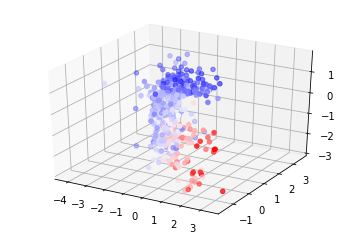

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.preprocessing import scale

# load data
file = "./src/tests/data/boston_housing.txt"
dataset = pd.read_csv(file)
X = dataset.values[:, 0:3]
Y_hat = dataset.values[:, 3][:, None]

# normalize data
X = scale(X, axis=0)
Y_hat = scale(Y_hat, axis=0)

# plot data
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y_hat, cmap='bwr')
plt.show()


The data exhibits non-linearity and thus represents an ideal benchmark for a two-layer ANN.

Using the framework developed throughout this lesson, we can elaborate on the already developed `FeedforwardModel` to build and train such an agent.


In [21]:
class FeedforwardModel():
    def __init__(self):
        self.__name__ = 'BostonHousingPrices'
        self.learning_rate = 0.001
        self.num_epochs = 20
        self.num_inputs = 3
        self.num_hidden = 4
        self.input_nodes = list()
        self.inference_graph = self._build_inference_graph(self.num_inputs, self.num_hidden)
        self.training_graph = self._build_training_graph()

    def _build_inference_graph(self, num_inputs, num_hidden):
        # input layer
        self.X = Placeholder()
        # hidden layer
        W1 = Variable(np.random.randn(num_inputs, num_hidden))
        B1 = Variable(np.zeros((1, num_hidden)))
        h = Add(Linear(self.X, W1), B1)
        act_h = ReLU(h)
        # output_layer
        W2 = Variable(np.random.randn(num_hidden, 1))
        B2 = Variable(np.zeros((1, 1)))
        self.y = Add(Linear(act_h, W2), B2)
        # build inference graph
        self.input_nodes.extend([self.X, W1, B1, W2, B2])
        graph = get_graph_flow(self.input_nodes)
        
        return graph
        
    def _build_training_graph(self):
        self.Y_hat = Placeholder()
        self.loss = MSE(self.Y_hat, self.y)
        # add Trainer
        self.input_nodes.extend([self.Y_hat])
        parameters = get_parameters_nodes(self.input_nodes)
        self.trainer = SGDWithMomentum(parameters, learning_rate=self.learning_rate)
        graph = get_graph_flow(self.input_nodes)
        
        return graph
        
    def _load_data(self):
        # load Boston housing prices data
        file = './src/tests/data/boston_housing.txt'
        dataset = pd.read_csv(file)
        X = dataset.values[:, 0:3]
        Y_hat = dataset.values[:, 3][:, None]
        # normalize data
        X = scale(X, axis=0)
        Y_hat = scale(Y_hat, axis=0)
        # create training and validation sets
        samples = list(zip(X, Y_hat))
        val = 0.10
        num_val_samples = int(val * len(samples))
        train_samples = samples[:num_val_samples]
        valid_samples = samples[num_val_samples:]
        
        return train_samples, valid_samples

    def train(self):
        train_samples, valid_samples = self._load_data()
        # training/validation statistics
        tr_errors = list()
        val_errors = list()
        for i_epoch in range(self.num_epochs):
            # training
            train_error = 0.0
            for sample in train_samples:
                x, y_hat = sample
                # forward pass
                self.X.forward(value=x[None, :])
                self.Y_hat.forward(value=y_hat[:, None])
                forward_prop(self.training_graph)
                train_error += self.loss.state
                # backward pass
                # compute gradients
                backward_prop(self.training_graph)
                self.trainer.update_gradients()
                # apply corrections
                self.trainer.apply_gradients()
            tr_errors.append(train_error/len(train_samples))
            # validation
            valid_error = 0
            for sample in valid_samples:
                x, y_hat = sample
                self.X.forward(value=x[None, :])
                self.Y_hat.forward(value=y_hat[:, None])
                forward_prop(self.training_graph)
                valid_error += self.loss.state
            val_errors.append(valid_error/len(valid_samples))
            print("Epoch {:2d} - Loss: {:4.2f}".format(i_epoch+1, val_errors[-1]))
        plt.plot(range(self.num_epochs), tr_errors, label='Training')
        plt.plot(range(self.num_epochs), val_errors, label='Validation')
        plt.legend()
        plt.show()
        
    def infer(self, x):
        self.X.forward(value=x)
        forward_prop(self.inference_graph)
        
        return self.y.state


A good practice when developing ANNs using Python framewors such as `deepteaching` and TensorFlow is to leverage Python's object-orientedness.
The model we built is decomposed into graph assembly, data preparation (notice the scaling preprocessing and the partitioning of samples in 90% training samples and 10% validation samples) and training.
Notice that during the validation phase, no backpropagation occurs, since validation is used to monitor how good is the model performance on data which has never been seen during training.


Epoch  1 - Loss: 1.93
Epoch  2 - Loss: 1.64
Epoch  3 - Loss: 1.43
Epoch  4 - Loss: 1.28
Epoch  5 - Loss: 1.17
Epoch  6 - Loss: 1.07
Epoch  7 - Loss: 1.00
Epoch  8 - Loss: 0.94
Epoch  9 - Loss: 0.88
Epoch 10 - Loss: 0.84
Epoch 11 - Loss: 0.81
Epoch 12 - Loss: 0.78
Epoch 13 - Loss: 0.76
Epoch 14 - Loss: 0.74
Epoch 15 - Loss: 0.73
Epoch 16 - Loss: 0.71
Epoch 17 - Loss: 0.70
Epoch 18 - Loss: 0.68
Epoch 19 - Loss: 0.67
Epoch 20 - Loss: 0.66


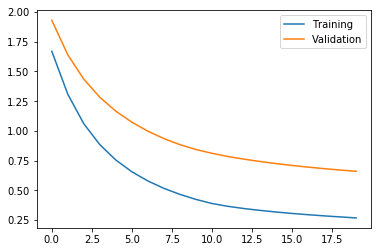

In [22]:
ff_model = FeedforwardModel()
ff_model.train()


### References

**Tensor derivatives**: this short [handouts](https://compsci697l.github.io/docs/vecDerivs.pdf) by Erik Learned-Miller are extremely clear and concise.
